In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [5]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
state_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.colums = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
status_counts = data['Estado'].value_counts().to_list()
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [49]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Casos activos VS Departamento (Estado)

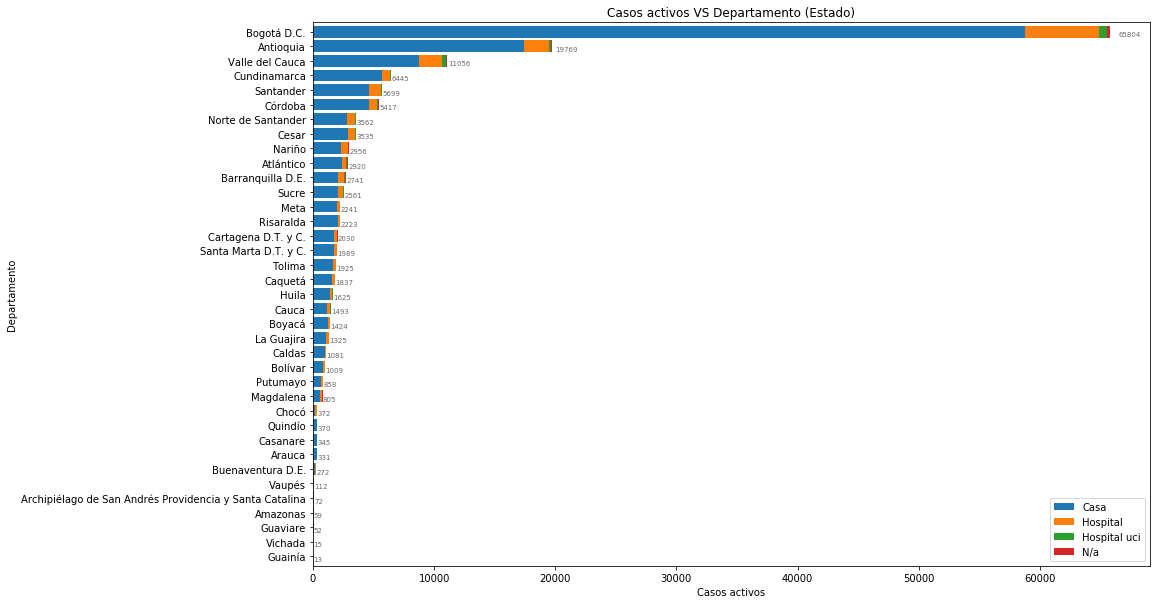

In [58]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos activos VS Departamento (Estado)'))
ax.set_xlabel('Casos activos')
ax.set_facecolor('w')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [12]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         58809.0    6099.0   
Antioquia                                           17404.0    2076.0   
Valle del Cauca                                      8732.0    1923.0   
Cundinamarca                                         5668.0     725.0   
Santander                                            4645.0     966.0   
Córdoba                                              4609.0     646.0   
Norte de Santander                                   2851.0     601.0   
Cesar                                                2926.0     544.0   
Nariño                                               2298.0     585.0   
Atlántico                                            2362.0     400.0   
Barranquilla D.E.                                    2093.0     499.0   
Sucre                                                2044.0     467.0   
Meta                                                 2023.0     191.0   
Risaralda                                            2054.0     150.0   
Cartagena D.T. y C.                                  1758.0     195.0   
Santa Marta D.T. y C.                                1719.0     242.0   
Tolima                                               1671.0     208.0   
Caquetá                                              1579.0     235.0   
Huila                                                1395.0     213.0   
Cauca                                                1121.0     306.0   
Boyacá                                               1257.0     139.0   
La Guajira                                           1072.0     218.0   
Caldas                                                963.0      95.0   
Bolívar                                               837.0     128.0   
Putumayo                                              672.0     175.0   
Magdalena                                             567.0     180.0   
Chocó                                                 200.0     142.0   
Quindío                                               342.0      25.0   
Casanare                                              304.0      37.0   
Arauca                                                300.0      28.0   
Buenaventura D.E.                                     150.0      98.0   
Vaupés                                                109.0       3.0   
Archipiélago de San Andrés Providencia y Santa ...     59.0      12.0   
Amazonas                                               47.0       7.0   
Guaviare                                               47.0       4.0   
Vichada                                                15.0       0.0   
Guainía                                                13.0       0.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                614.0  282.0   
Antioquia                                                  203.0   86.0   
Valle del Cauca                                            302.0   99.0   
Cundinamarca                                                25.0   27.0   
Santander                                                   66.0   22.0   
Córdoba                                                     89.0   73.0   
Norte de Santander                                          99.0   11.0   
Cesar                                                       52.0   13.0   
Nariño                                                      46.0   27.0   
Atlántico                                                   73.0   85.0   
Barranquilla D.E.                                           53.0   96.0   
Sucre                                                       30.0   20.0   
Meta                                                        12.0   15.0   
Risaralda                  

### - Recuperados VS Departamento

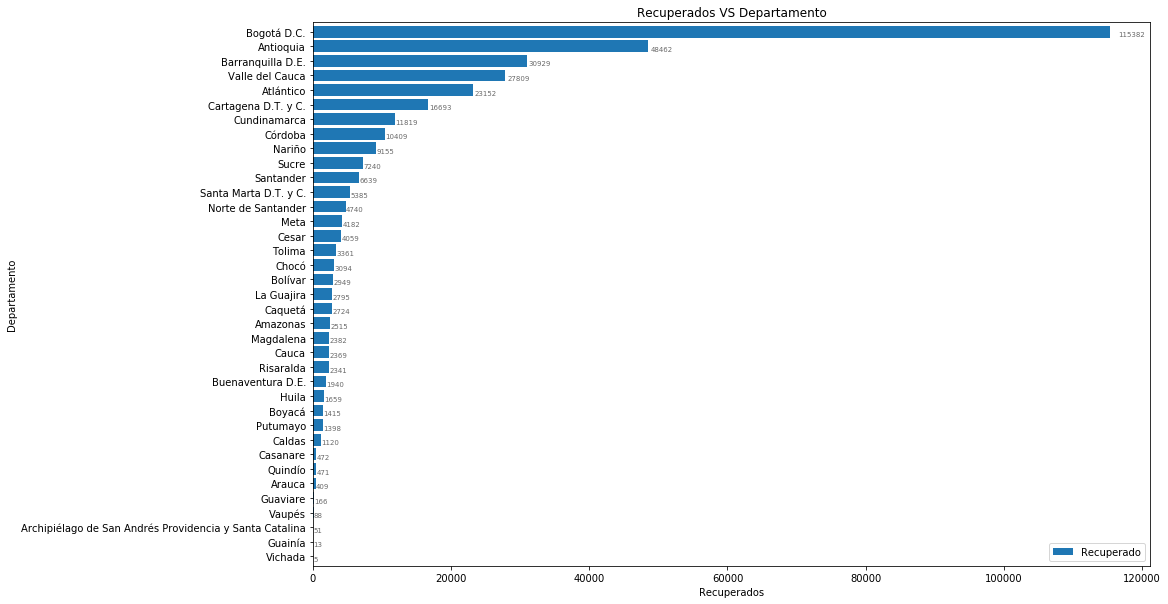

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, False, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Recuperados VS Departamento'))
ax.set_xlabel('Recuperados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                              Recuperado     Total
Departamento                                                            
Bogotá D.C.                                           115382.0  115382.0
Antioquia                                              48462.0   48462.0
Barranquilla D.E.                                      30929.0   30929.0
Valle del Cauca                                        27809.0   27809.0
Atlántico                                              23152.0   23152.0
Cartagena D.T. y C.                                    16693.0   16693.0
Cundinamarca                                           11819.0   11819.0
Córdoba                                                10409.0   10409.0
Nariño                                                  9155.0    9155.0
Sucre                                                   7240.0    7240.0
Santander                                               6639.0    6639.0
Santa Marta D.T. y C.                                   5385.0    5385.0
Norte de Santander                                      4740.0    4740.0
Meta                                                    4182.0    4182.0
Cesar                                                   4059.0    4059.0
Tolima                                                  3361.0    3361.0
Chocó                                                   3094.0    3094.0
Bolívar                                                 2949.0    2949.0
La Guajira                                              2795.0    2795.0
Caquetá                                                 2724.0    2724.0
Amazonas                                                2515.0    2515.0
Magdalena                                               2382.0    2382.0
Cauca                                                   2369.0    2369.0
Risaralda                                               2341.0    2341.0
Buenaventura D.E.                                       1940.0    1940.0
Huila                                                   1659.0    1659.0
Boyacá                                                  1415.0    1415.0
Putumayo                                                1398.0    1398.0
Caldas                                                  1120.0    1120.0
Casanare                                                 472.0     472.0
Quindío                                                  471.0     471.0
Arauca                                                   409.0     409.0
Guaviare                                                 166.0     166.0
Vaupés                                                    88.0      88.0
Archipiélago de San Andrés Providencia y Santa ...        51.0      51.0
Guainía                                                   13.0      13.0
Vichada                                                    5.0       5.0

### - Fallecidos VS Departamento

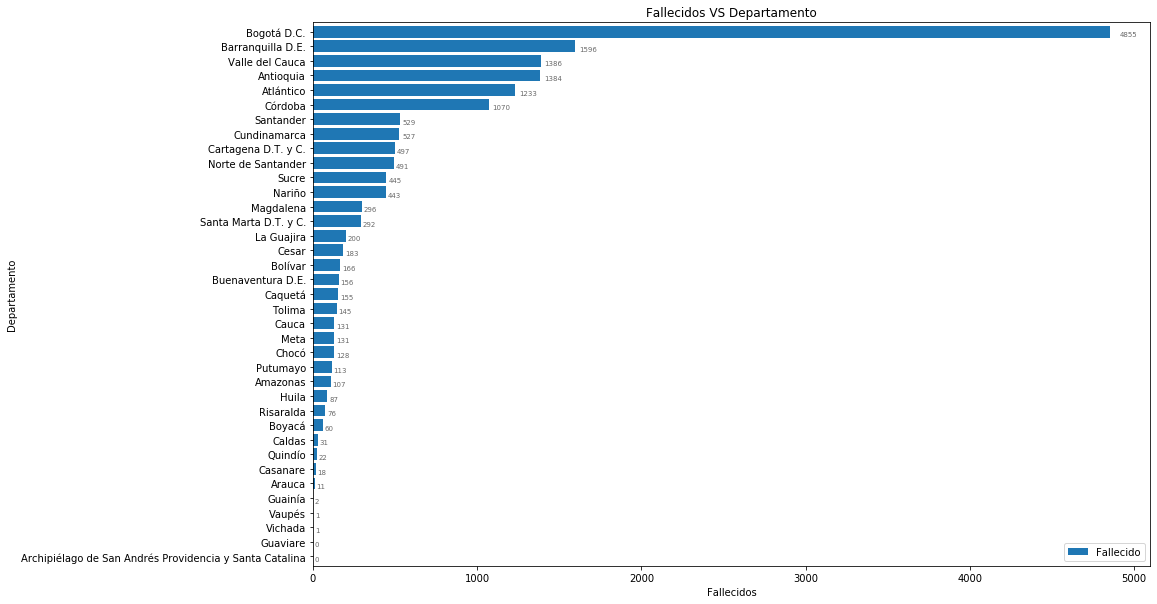

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Fallecidos VS Departamento'))
ax.set_xlabel('Fallecidos')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                              Fallecido   Total
Departamento                                                         
Bogotá D.C.                                            4855.0  4855.0
Barranquilla D.E.                                      1596.0  1596.0
Valle del Cauca                                        1386.0  1386.0
Antioquia                                              1384.0  1384.0
Atlántico                                              1233.0  1233.0
Córdoba                                                1070.0  1070.0
Santander                                               529.0   529.0
Cundinamarca                                            527.0   527.0
Cartagena D.T. y C.                                     497.0   497.0
Norte de Santander                                      491.0   491.0
Sucre                                                   445.0   445.0
Nariño                                                  443.0   443.0
Magdalena                                               296.0   296.0
Santa Marta D.T. y C.                                   292.0   292.0
La Guajira                                              200.0   200.0
Cesar                                                   183.0   183.0
Bolívar                                                 166.0   166.0
Buenaventura D.E.                                       156.0   156.0
Caquetá                                                 155.0   155.0
Tolima                                                  145.0   145.0
Meta                                                    131.0   131.0
Cauca                                                   131.0   131.0
Chocó                                                   128.0   128.0
Putumayo                                                113.0   113.0
Amazonas                                                107.0   107.0
Huila                                                    87.0    87.0
Risaralda                                                76.0    76.0
Boyacá                                                   60.0    60.0
Caldas                                                   31.0    31.0
Quindío                                                  22.0    22.0
Casanare                                                 18.0    18.0
Arauca                                                   11.0    11.0
Guainía                                                   2.0     2.0
Vaupés                                                    1.0     1.0
Vichada                                                   1.0     1.0
Guaviare                                                  0.0     0.0
Archipiélago de San Andrés Providencia y Santa ...        0.0     0.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

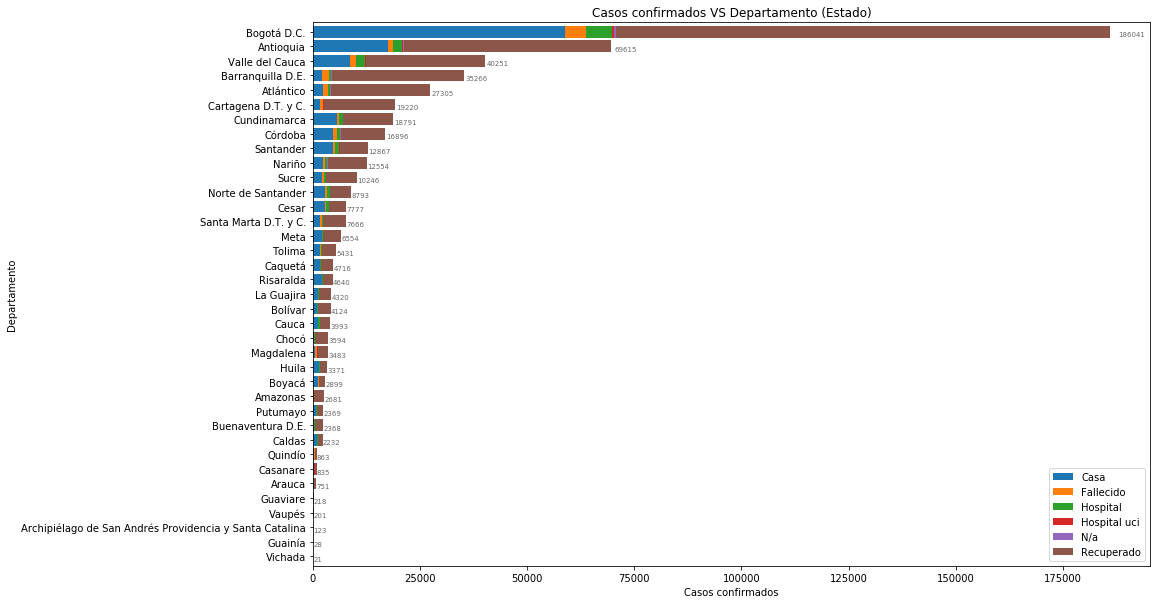

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         58809.0     4855.0   
Antioquia                                           17404.0     1384.0   
Valle del Cauca                                      8732.0     1386.0   
Barranquilla D.E.                                    2093.0     1596.0   
Atlántico                                            2362.0     1233.0   
Cartagena D.T. y C.                                  1758.0      497.0   
Cundinamarca                                         5668.0      527.0   
Córdoba                                              4609.0     1070.0   
Santander                                            4645.0      529.0   
Nariño                                               2298.0      443.0   
Sucre                                                2044.0      445.0   
Norte de Santander                                   2851.0      491.0   
Cesar                                                2926.0      183.0   
Santa Marta D.T. y C.                                1719.0      292.0   
Meta                                                 2023.0      131.0   
Tolima                                               1671.0      145.0   
Caquetá                                              1579.0      155.0   
Risaralda                                            2054.0       76.0   
La Guajira                                           1072.0      200.0   
Bolívar                                               837.0      166.0   
Cauca                                                1121.0      131.0   
Chocó                                                 200.0      128.0   
Magdalena                                             567.0      296.0   
Huila                                                1395.0       87.0   
Boyacá                                               1257.0       60.0   
Amazonas                                               47.0      107.0   
Putumayo                                              672.0      113.0   
Buenaventura D.E.                                     150.0      156.0   
Caldas                                                963.0       31.0   
Quindío                                               342.0       22.0   
Casanare                                              304.0       18.0   
Arauca                                                300.0       11.0   
Guaviare                                               47.0        0.0   
Vaupés                                                109.0        1.0   
Archipiélago de San Andrés Providencia y Santa ...     59.0        0.0   
Guainía                                                13.0        2.0   
Vichada                                                15.0        1.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6099.0         614.0   
Antioquia                                             2076.0         203.0   
Valle del Cauca                                       1923.0         302.0   
Barranquilla D.E.                                      499.0          53.0   
Atlántico                                              400.0          73.0   
Cartagena D.T. y C.                                    195.0          44.0   
Cundinamarca                                           725.0          25.0   
Córdoba                                                646.0          89.0   
Santander                                              966.0          66.0   
Nariño                                                 585.0          46.0   
Sucre                                                  467.0          30.0   
Norte de Santander                                     601.0          99.0   
Cesar                

### - Casos confirmados VS Departamento (Sexo)

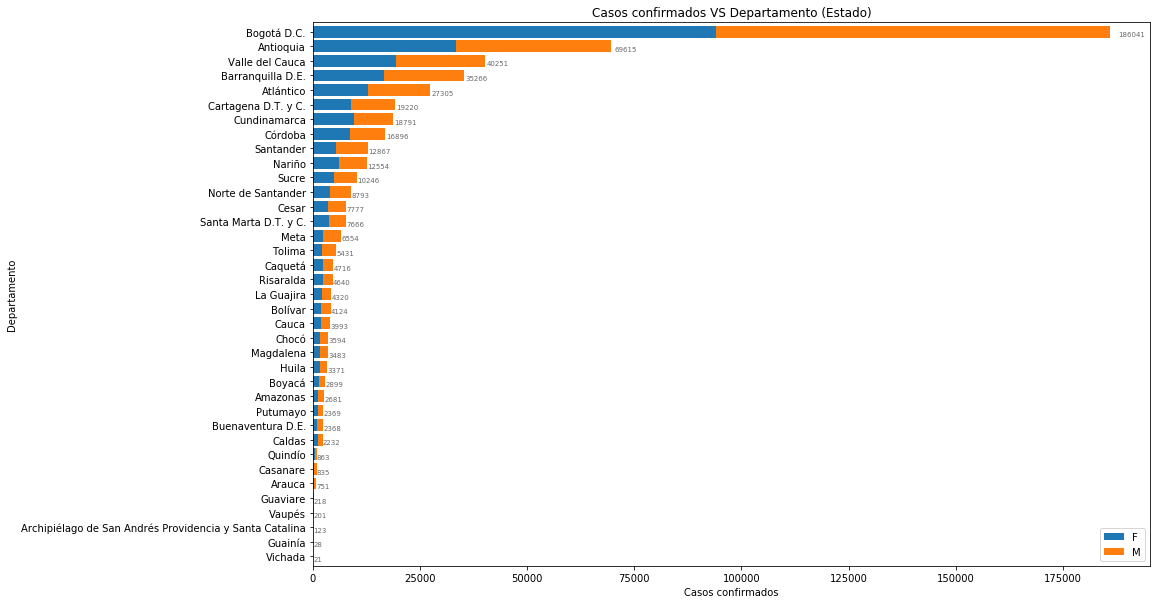

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
ax.legend(loc='lower right')
div = len(li.columns)-1
numbers_H(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                    F      M   Total
Departamento                                                            
Bogotá D.C.                                         94031  92010  186041
Antioquia                                           33280  36335   69615
Valle del Cauca                                     19440  20811   40251
Barranquilla D.E.                                   16559  18707   35266
Atlántico                                           12949  14356   27305
Cartagena D.T. y C.                                  8819  10401   19220
Cundinamarca                                         9489   9302   18791
Córdoba                                              8751   8145   16896
Santander                                            5471   7396   12867
Nariño                                               5992   6562   12554
Sucre                                                4918   5328   10246
Norte de Santander                                   3967   4826    8793
Cesar                                                3560   4217    7777
Santa Marta D.T. y C.                                3855   3811    7666
Meta                                                 2377   4177    6554
Tolima                                               2117   3314    5431
Caquetá                                              2343   2373    4716
Risaralda                                            2274   2366    4640
La Guajira                                           2176   2144    4320
Bolívar                                              1884   2240    4124
Cauca                                                1853   2140    3993
Chocó                                                1695   1899    3594
Magdalena                                            1757   1726    3483
Huila                                                1683   1688    3371
Boyacá                                               1374   1525    2899
Amazonas                                             1160   1521    2681
Putumayo                                             1073   1296    2369
Buenaventura D.E.                                     883   1485    2368
Caldas                                               1074   1158    2232
Quindío                                               426    437     863
Casanare                                              350    485     835
Arauca                                                228    523     751
Guaviare                                               32    186     218
Vaupés                                                 89    112     201
Archipiélago de San Andrés Providencia y Santa ...     69     54     123
Guainía                                                10     18      28
Vichada                                                 4     17      21

### - Dataset COVID-19 (Colombia)

In [21]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
533139               2020-08-22           2020-08-20            2020-08-14   
533140               2020-08-22           2020-08-21            2020-08-16   
533141               2020-08-22           2020-08-20            2020-08-16   
533142               2020-08-22           2020-08-20            2020-08-17   
533143               2020-08-22           2020-08-21            2020-08-16   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
533139             2020-08-14 00:00:00                   NaT   
533140             2020-08-16 00:00:00                   NaT   
533141             2020-08-11 00:00:00                   NaT   
533142             2020-08-11 00:00:00                   NaT   
533143             2020-08-08 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
533139                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
533140                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
533141                    NaT          Bogotá d.c.      Bogotá D.C.  Moderado   
533142                    NaT          Bogotá d.c.      Bogotá D.C.      Leve   
533143                    NaT          Bogotá d.c.      Bogotá D.C.  Moderado   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
533139            Casa  ...                60 - 70    F               NaN   
533140            Casa  ...                40 - 50    F               NaN   
533141        Hospital  ...                70 - 80    M               NaN   
533142            Casa  ...                60 - 70    F               NaN   
533143        Hospital  ...                80 - 90    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Mapa de influencia COVID-19 (Colombia)

In [48]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

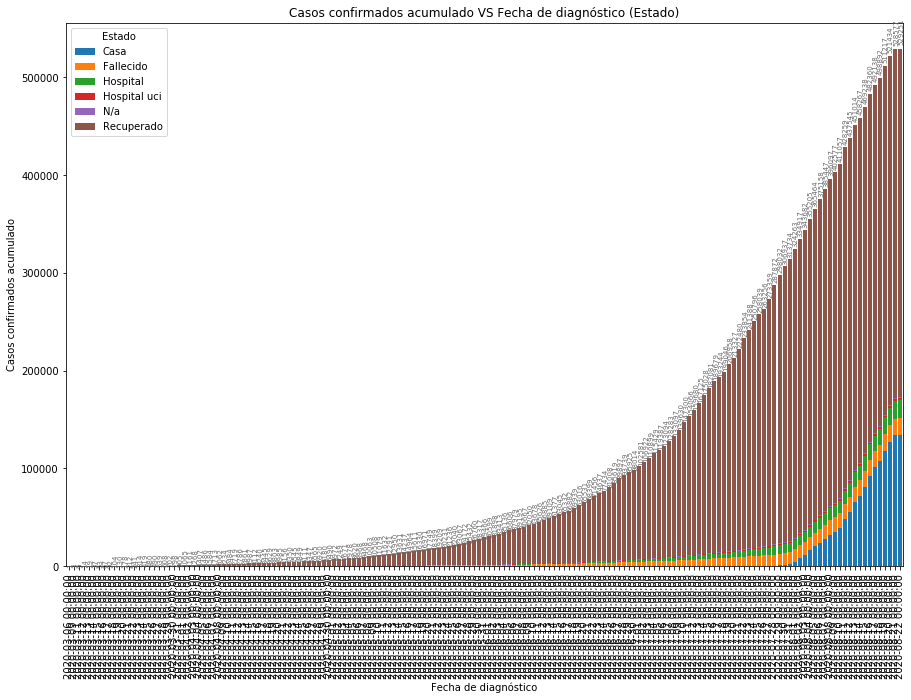

In [23]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [24]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-08-22            134693.0    16767.0   18476.0        1974.0  1045.0   
2020-08-21            134077.0    16767.0   18425.0        1967.0  1045.0   
2020-08-20            127454.0    16762.0   17938.0        1940.0  1045.0   
2020-08-19            118329.0    16624.0   17166.0        1903.0  1040.0   
2020-08-18            107245.0    16506.0   16591.0        1894.0  1031.0   
2020-08-17            101134.0    16387.0   16169.0        1893.0  1023.0   
2020-08-16             92423.0    16299.0   15803.0        1889.0  1020.0   
2020-08-15             81211.0    16126.0   15317.0        1887.0  1015.0   
2020-08-14             71892.0    15942.0   14816.0        1873.0  1009.0   
2020-08-13             65761.0    15778.0   14479.0        1862.0  1002.0   
2020-08-12             55754.0    15559.0   13949.0        1841.0   990.0   
2020-08-11             48626.0    15312.0   13422.0        1817.0   982.0   
2020-08-10             39042.0    15000.0   12717.0        1757.0   967.0   
2020-08-09             35172.0    14829.0   12356.0        1738.0   952.0   
2020-08-08             32493.0    14650.0   12022.0        1710.0   948.0   
2020-08-07             27936.0    14395.0   11704.0        1667.0   937.0   
2020-08-06             23888.0    14163.0   11355.0        1611.0   922.0   
2020-08-05             20364.0    13918.0   11046.0        1559.0   905.0   
2020-08-04             16161.0    13674.0   10684.0        1508.0   888.0   
2020-08-03             11166.0    13389.0   10349.0        1456.0   874.0   
2020-08-02              8590.0    13091.0    9957.0        1413.0   858.0   
2020-08-01              4724.0    12756.0    9551.0        1370.0   844.0   
2020-07-31              1944.0    12436.0    9100.0        1333.0   825.0   
2020-07-30              1481.0    12221.0    8859.0        1309.0   810.0   
2020-07-29               839.0    11947.0    8588.0        1262.0   797.0   
2020-07-28               351.0    11680.0    8267.0        1211.0   777.0   
2020-07-27               260.0    11161.0    7750.0        1152.0   743.0   
2020-07-26               186.0    10860.0    7461.0        1112.0   724.0   
2020-07-25               169.0    10630.0    7270.0        1084.0   715.0   
2020-07-24               161.0    10336.0    6958.0        1045.0   703.0   
2020-07-23               141.0    10048.0    6646.0        1007.0   683.0   
2020-07-22               122.0     9686.0    6299.0         968.0   656.0   
2020-07-21               106.0     9257.0    5870.0         912.0   631.0   
2020-07-20                94.0     8917.0    5583.0         858.0   618.0   
2020-07-19                91.0     8651.0    5261.0         825.0   609.0   
2020-07-18                79.0     8376.0    4991.0         800.0   592.0   
2020-07-17                76.0     8139.0    4811.0         770.0   571.0   
2020-07-16                72.0     7970.0    4701.0         755.0   563.0   
2020-07-15                67.0     7691.0    4440.0         718.0   544.0   
2020-07-14                57.0     7400.0    4219.0         683.0   535.0   
2020-07-13                55.0     7116.0    3982.0         653.0   513.0   
2020-07-12                50.0     6850.0    3728.0         618.0   492.0   
2020-07-11                43.0     6639.0    3571.0         589.0   478.0   
2020-07-10                33.0     6382.0    3358.0         569.0   452.0   
2020-07-09                28.0     6163.0    3159.0         540.0   436.0   
2020-07-08                24.0     5870.0    2904.0         497.0   427.0   
2020-07-07                23.0     5631.0    2754.0         470.0   418.0   
2020-07-06                22.0     5419.0    2555.0         441.0   400.0   
2020-07-05                20.0     5288.0    2475.0         427.0   388.0   
2020-07-04                19.0     5138.0    2375.0         410.0   373.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

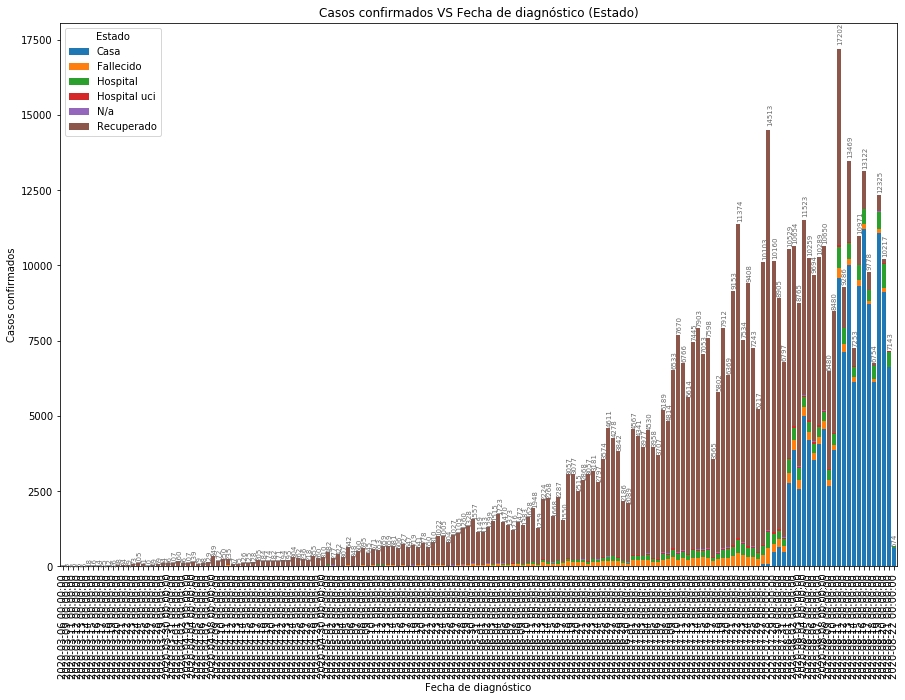

In [25]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [26]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-08-22              616.0        0.0      51.0           7.0   0.0   
2020-08-21             6623.0        5.0     487.0          27.0   0.0   
2020-08-20             9125.0      138.0     772.0          37.0   5.0   
2020-08-19            11084.0      118.0     575.0           9.0   9.0   
2020-08-18             6111.0      119.0     422.0           1.0   8.0   
2020-08-17             8711.0       88.0     366.0           4.0   3.0   
2020-08-16            11212.0      173.0     486.0           2.0   5.0   
2020-08-15             9319.0      184.0     501.0          14.0   6.0   
2020-08-14             6131.0      164.0     337.0          11.0   7.0   
2020-08-13            10007.0      219.0     530.0          21.0  12.0   
2020-08-12             7128.0      247.0     527.0          24.0   8.0   
2020-08-11             9584.0      312.0     705.0          60.0  15.0   
2020-08-10             3870.0      171.0     361.0          19.0  15.0   
2020-08-09             2679.0      179.0     334.0          28.0   4.0   
2020-08-08             4557.0      255.0     318.0          43.0  11.0   
2020-08-07             4048.0      232.0     349.0          56.0  15.0   
2020-08-06             3524.0      245.0     309.0          52.0  17.0   
2020-08-05             4203.0      244.0     362.0          51.0  17.0   
2020-08-04             4995.0      285.0     335.0          52.0  14.0   
2020-08-03             2576.0      298.0     392.0          43.0  16.0   
2020-08-02             3866.0      335.0     406.0          43.0  14.0   
2020-08-01             2780.0      320.0     451.0          37.0  19.0   
2020-07-31              463.0      215.0     241.0          24.0  15.0   
2020-07-30              642.0      274.0     271.0          47.0  13.0   
2020-07-29              488.0      267.0     321.0          51.0  20.0   
2020-07-28               91.0      519.0     517.0          59.0  34.0   
2020-07-27               74.0      301.0     289.0          40.0  19.0   
2020-07-26               17.0      230.0     191.0          28.0   9.0   
2020-07-25                8.0      294.0     312.0          39.0  12.0   
2020-07-24               20.0      288.0     312.0          38.0  20.0   
2020-07-23               19.0      362.0     347.0          39.0  27.0   
2020-07-22               16.0      429.0     429.0          56.0  25.0   
2020-07-21               12.0      340.0     287.0          54.0  13.0   
2020-07-20                3.0      266.0     322.0          33.0   9.0   
2020-07-19               12.0      275.0     270.0          25.0  17.0   
2020-07-18                3.0      237.0     180.0          30.0  21.0   
2020-07-17                4.0      169.0     110.0          15.0   8.0   
2020-07-16                5.0      279.0     261.0          37.0  19.0   
2020-07-15               10.0      291.0     221.0          35.0   9.0   
2020-07-14                2.0      284.0     237.0          30.0  22.0   
2020-07-13                5.0      266.0     254.0          35.0  21.0   
2020-07-12                7.0      211.0     157.0          29.0  14.0   
2020-07-11               10.0      257.0     213.0          20.0  26.0   
2020-07-10                5.0      219.0     199.0          29.0  16.0   
2020-07-09                4.0      293.0     255.0          43.0   9.0   
2020-07-08                1.0      239.0     150.0          27.0   9.0   
2020-07-07                1.0      212.0     199.0          29.0  18.0   
2020-07-06                2.0      131.0      80.0          14.0  12.0   
2020-07-05                1.0      150.0     100.0          17.0  15.0   
2020-07-04                5.0      193.0     189.0          26.0  19.0   
2020-07-03                1.0      198.0     130.0          13.0   9.0   
2020-07-02                5.0      205.0     138.0          25.0  12.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

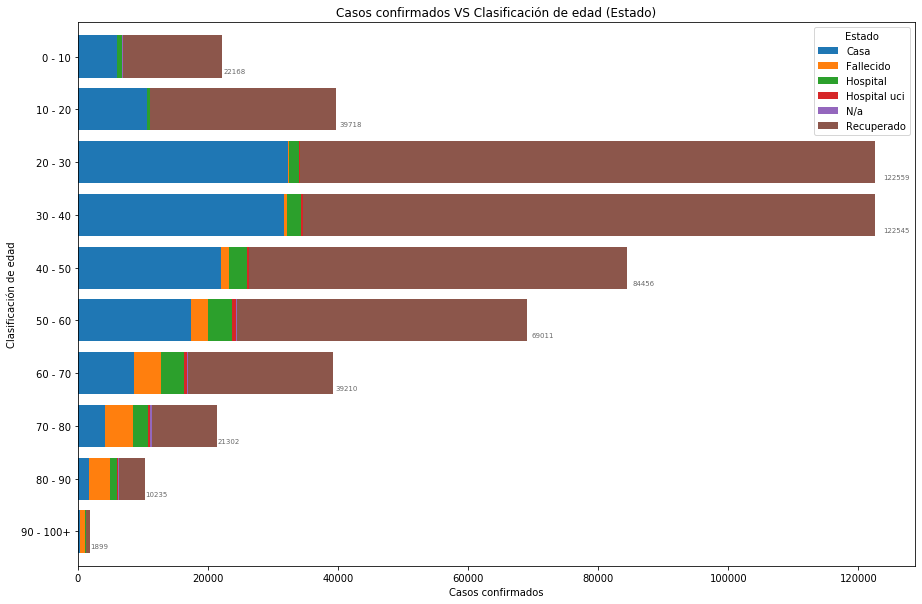

In [27]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [28]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  5946         30       803            53   26   
10 - 20                10615         26       404            34   20   
20 - 30                32301        220      1517            77   48   
30 - 40                31622        561      2186           186   38   
40 - 50                21990       1260      2696           295   85   
50 - 60                17407       2583      3766           491  131   
60 - 70                 8648       4107      3516           467  219   
70 - 80                 4117       4295      2368           292  249   
80 - 90                 1762       3166      1128            85  208   
90 - 100+                307        720       178            10   52   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      15310  
10 - 20                     28619  
20 - 30                     88396  
30 - 40                     87952  
40 - 50                     58130  
50 - 60                     44633  
60 - 70                     22253  
70 - 80                      9981  
80 - 90                      3886  
90 - 100+                     632

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

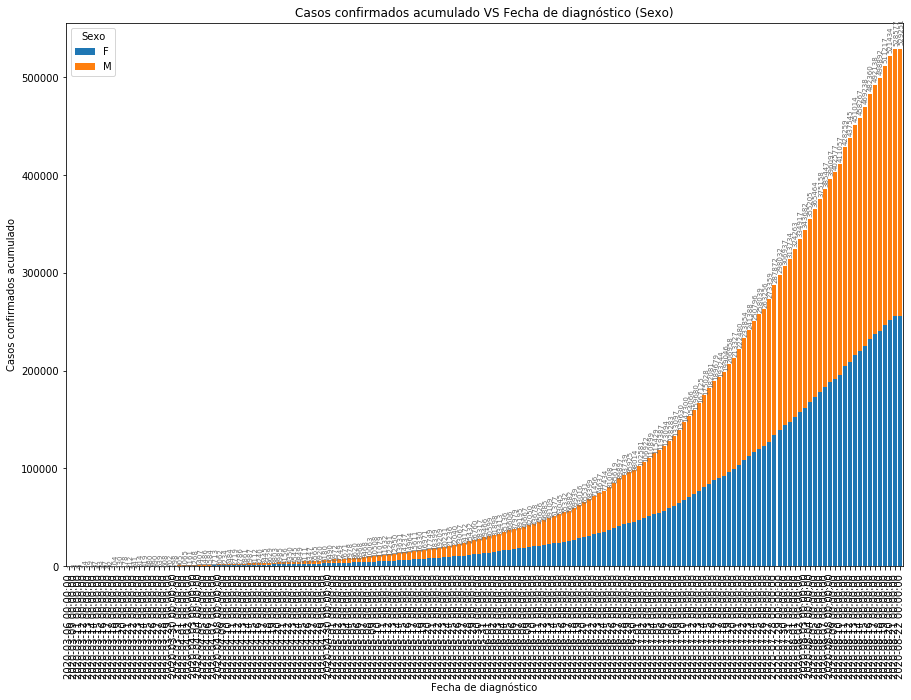

In [29]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [30]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-08-22            256190.0  273061.0
2020-08-21            255893.0  272684.0
2020-08-20            252237.0  269197.0
2020-08-19            247035.0  264182.0
2020-08-18            240626.0  258266.0
2020-08-17            237339.0  254799.0
2020-08-16            232170.0  250190.0
2020-08-15            225302.0  243936.0
2020-08-14            219694.0  238573.0
2020-08-13            215981.0  235033.0
2020-08-12            209235.0  228310.0
2020-08-11            204641.0  223618.0
2020-08-10            195720.0  215337.0
2020-08-09            191466.0  211111.0
2020-08-08            188123.0  207974.0
2020-08-07            182929.0  202518.0
2020-08-06            177897.0  197261.0
2020-08-05            173096.0  192368.0
2020-08-04            167948.0  187257.0
2020-08-03            162177.0  181505.0
2020-08-02            157932.0  176985.0
2020-08-01            152481.0  171782.0
2020-07-31            147382.0  166352.0
2020-07-30            143964.0  162973.0
2020-07-29            139640.0  158392.0
2020-07-28            134595.0  153277.0
2020-07-27            127525.0  145834.0
2020-07-26            122682.0  140574.0
2020-07-25            120292.0  137747.0
2020-07-24            116628.0  134168.0
2020-07-23            112283.0  129105.0
2020-07-22            108724.0  125130.0
2020-07-21            103590.0  118890.0
2020-07-20             99308.0  114019.0
2020-07-19             96333.0  110625.0
2020-07-18             92544.0  106502.0
2020-07-17             89765.0  103479.0
2020-07-16             88008.0  101671.0
2020-07-15             84278.0   97803.0
2020-07-14             80933.0   94095.0
2020-07-13             77337.0   89788.0
2020-07-12             73769.0   85911.0
2020-07-11             71096.0   82970.0
2020-07-10             67883.0   79417.0
2020-07-09             64379.0   75251.0
2020-07-08             61414.0   71683.0
2020-07-07             59105.0   69178.0
2020-07-06             56696.0   66398.0
2020-07-05             54945.0   64442.0
2020-07-04             53111.0   62318.0
2020-07-03             51082.0   59817.0
2020-07-02             49226.0   57696.0
2020-07-01             47197.0   55384.0
2020-06-30             45122.0   52892.0
2020-06-29             44149.0   51776.0
2020-06-28             43149.0   50590.0
2020-06-27             41309.0   48588.0
2020-06-26             39312.0   46307.0
2020-06-25             37118.0   43890.0
2020-06-24             35548.0   41886.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

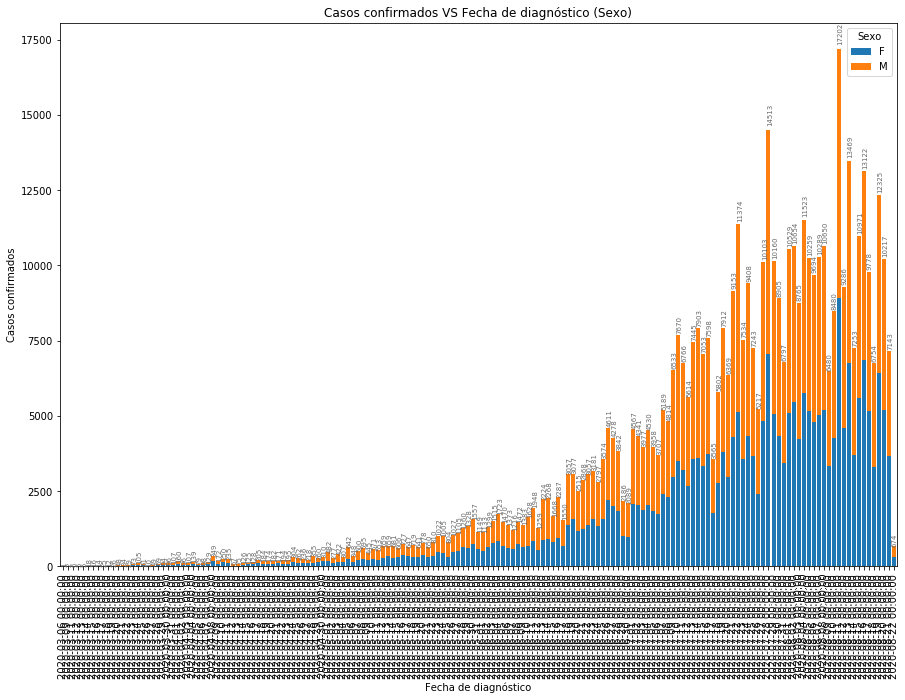

In [31]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [32]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-08-22             297.0   377.0
2020-08-21            3656.0  3487.0
2020-08-20            5202.0  5015.0
2020-08-19            6409.0  5916.0
2020-08-18            3287.0  3467.0
2020-08-17            5169.0  4609.0
2020-08-16            6868.0  6254.0
2020-08-15            5608.0  5363.0
2020-08-14            3713.0  3540.0
2020-08-13            6746.0  6723.0
2020-08-12            4594.0  4692.0
2020-08-11            8921.0  8281.0
2020-08-10            4254.0  4226.0
2020-08-09            3343.0  3137.0
2020-08-08            5194.0  5456.0
2020-08-07            5032.0  5257.0
2020-08-06            4801.0  4893.0
2020-08-05            5148.0  5111.0
2020-08-04            5771.0  5752.0
2020-08-03            4245.0  4520.0
2020-08-02            5451.0  5203.0
2020-08-01            5099.0  5430.0
2020-07-31            3418.0  3379.0
2020-07-30            4324.0  4581.0
2020-07-29            5045.0  5115.0
2020-07-28            7070.0  7443.0
2020-07-27            4843.0  5260.0
2020-07-26            2390.0  2827.0
2020-07-25            3664.0  3579.0
2020-07-24            4345.0  5063.0
2020-07-23            3559.0  3975.0
2020-07-22            5134.0  6240.0
2020-07-21            4282.0  4871.0
2020-07-20            2975.0  3394.0
2020-07-19            3789.0  4123.0
2020-07-18            2779.0  3023.0
2020-07-17            1757.0  1808.0
2020-07-16            3730.0  3868.0
2020-07-15            3345.0  3708.0
2020-07-14            3596.0  4307.0
2020-07-13            3568.0  3877.0
2020-07-12            2673.0  2941.0
2020-07-11            3213.0  3553.0
2020-07-10            3504.0  4166.0
2020-07-09            2965.0  3568.0
2020-07-08            2309.0  2505.0
2020-07-07            2409.0  2780.0
2020-07-06            1751.0  1956.0
2020-07-05            1834.0  2124.0
2020-07-04            2029.0  2501.0
2020-07-03            1856.0  2121.0
2020-07-02            2029.0  2312.0
2020-07-01            2075.0  2492.0
2020-06-30             973.0  1116.0
2020-06-29            1000.0  1186.0
2020-06-28            1840.0  2002.0
2020-06-27            1997.0  2281.0
2020-06-26            2194.0  2417.0
2020-06-25            1570.0  2004.0
2020-06-24            1345.0  1452.0

### - Casos confirmados VS Clasificación de edad (Sexo)

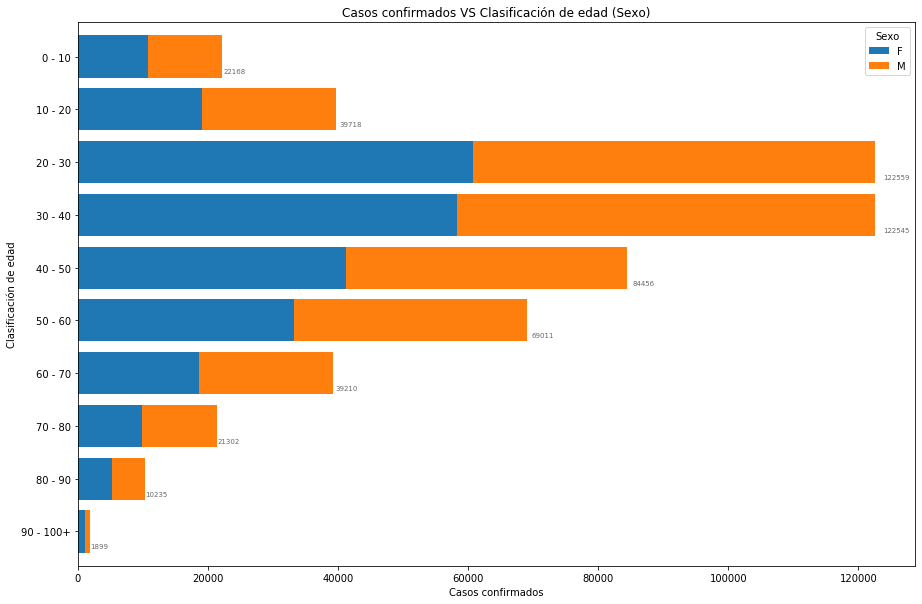

In [33]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [34]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 10830  11338
10 - 20                19021  20697
20 - 30                60733  61826
30 - 40                58234  64311
40 - 50                41189  43267
50 - 60                33246  35765
60 - 70                18557  20653
70 - 80                 9908  11394
80 - 90                 5207   5028
90 - 100+               1087    812

### - Casos confirmados VS Estado (Sexo)

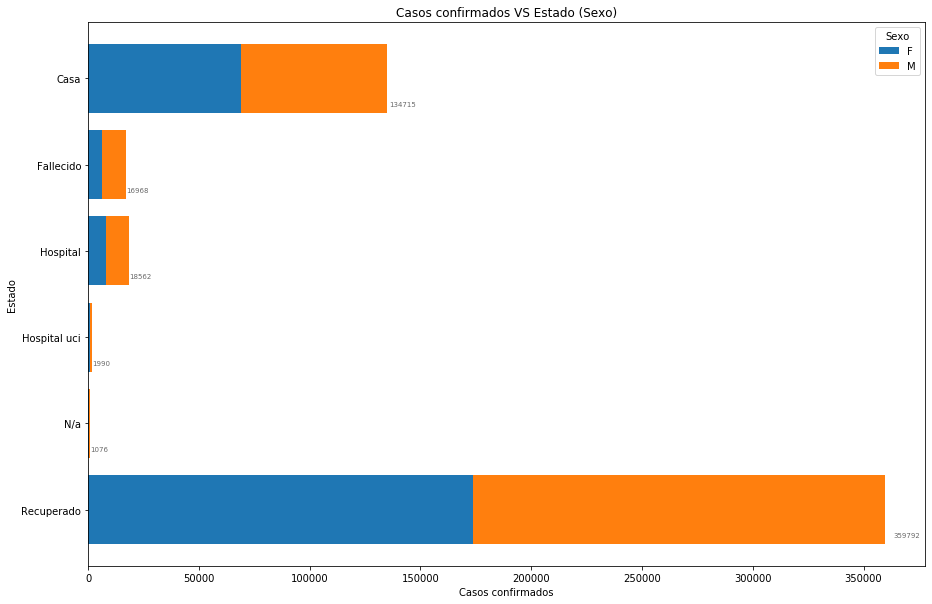

In [35]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [36]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           68936   65779
Fallecido       6090   10878
Hospital        7949   10613
Hospital uci     695    1295
N/a              459     617
Recuperado    173883  185909

### - Casos confirmados VS Tipo de contagio (Sexo)

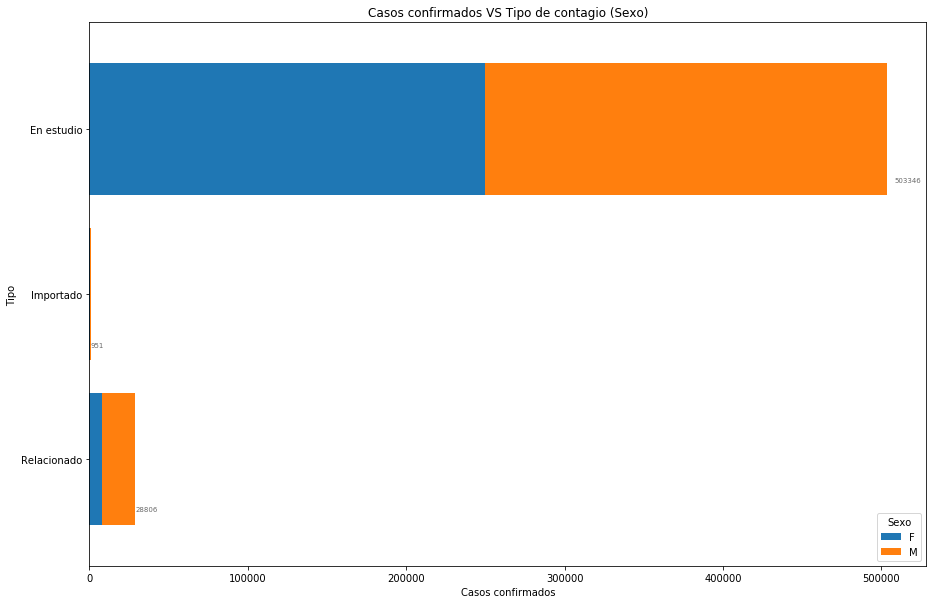

In [37]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [38]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   249640  253706
Importado       446     505
Relacionado    7926   20880

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

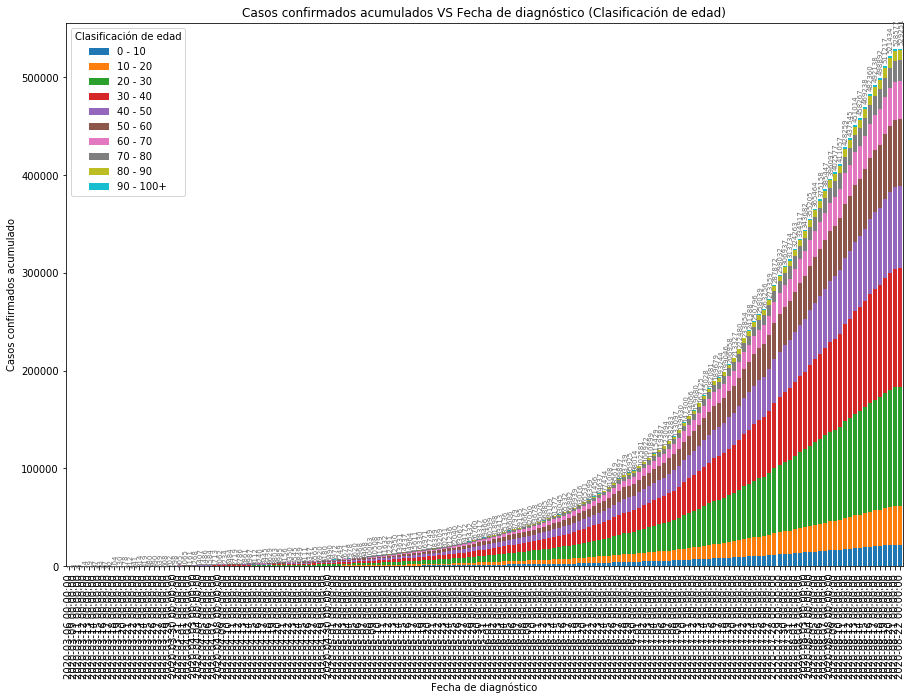

In [39]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [40]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-22              22033    39442   121648   121618    83891    68540   
2020-08-21              22014    39406   121464   121445    83789    68462   
2020-08-20              21732    38883   119745   119848    82654    67516   
2020-08-19              21319    38130   117484   117619    81058    66139   
2020-08-18              20727    37213   114706   114872    79046    64598   
2020-08-17              20500    36754   113262   113368    77963    63641   
2020-08-16              19992    36008   111095   111316    76401    62335   
2020-08-15              19380    34886   108167   108453    74314    60618   
2020-08-14              18885    34068   105664   106021    72591    59148   
2020-08-13              18635    33547   104011   104406    71424    58130   
2020-08-12              18020    32493   100977   101363    69269    56355   
2020-08-11              17682    31869    98946    99235    67791    55116   
2020-08-10              16896    30641    94901    95243    64984    52903   
2020-08-09              16570    29968    92986    93268    63664    51810   
2020-08-08              16330    29549    91489    91864    62591    50938   
2020-08-07              15916    28770    89082    89270    60919    49543   
2020-08-06              15503    28001    86729    86842    59284    48212   
2020-08-05              15056    27260    84577    84630    57732    46951   
2020-08-04              14630    26544    82225    82260    56075    45597   
2020-08-03              14143    25733    79577    79572    54186    44018   
2020-08-02              13820    25128    77591    77530    52851    42809   
2020-08-01              13379    24408    75185    75146    51050    41313   
2020-07-31              12967    23554    72635    72646    49434    39980   
2020-07-30              12695    23102    71118    71022    48272    39147   
2020-07-29              12352    22393    68952    68904    46962    37988   
2020-07-28              11972    21652    66537    66441    45284    36755   
2020-07-27              11345    20528    63223    63166    42975    34836   
2020-07-26              10959    19810    60845    60793    41315    33637   
2020-07-25              10748    19485    59657    59570    40506    32957   
2020-07-24              10466    19004    58023    57874    39346    31977   
2020-07-23              10145    18286    55824    55591    37874    30754   
2020-07-22               9868    17771    54145    53847    36677    29765   
2020-07-21               9463    16929    51438    51263    34900    28225   
2020-07-20               9102    16305    49282    49087    33422    27076   
2020-07-19               8825    15845    47928    47627    32354    26247   
2020-07-18               8512    15185    46094    45772    31044    25265   
2020-07-17               8290    14843    44800    44357    30088    24513   
2020-07-16               8167    14624    43999    43496    29541    24059   
2020-07-15               7825    14119    42293    41693    28296    23042   
2020-07-14               7532    13585    40696    40085    27171    22113   
2020-07-13               7236    13003    38828    38207    25895    21137   
2020-07-12               6981    12514    37046    36493    24681    20149   
2020-07-11               6740    12089    35736    35220    23767    19407   
2020-07-10               6489    11641    34106    33589    22682    18551   
2020-07-09               6204    11091    32251    31706    21524    17563   
2020-07-08               5984    10663    30697    30136    20484    16750   
2020-07-07               5794    10337    29605    28993    19714    16126   
2020-07-06               5594    10040    28377    27725    18825    15483   
2020-07-05               5415     9754    27566    26838    18251    14998   
2020-07-04            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

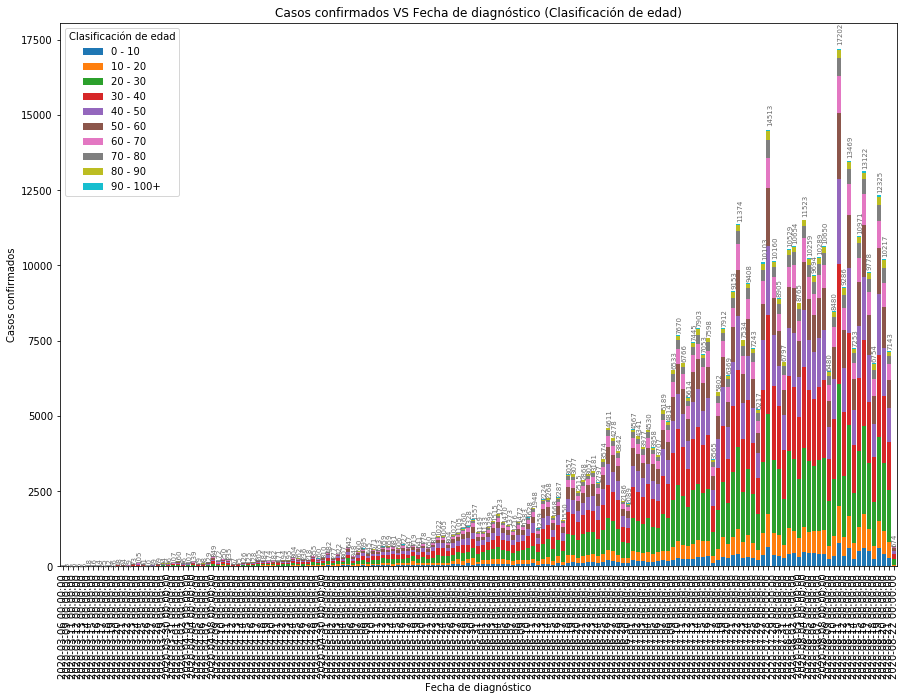

In [41]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [42]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-08-22                 19       36      184      173      102       78   
2020-08-21                282      523     1719     1597     1135      946   
2020-08-20                413      753     2261     2229     1596     1377   
2020-08-19                592      917     2778     2747     2012     1541   
2020-08-18                227      459     1444     1504     1083      957   
2020-08-17                508      746     2167     2052     1562     1306   
2020-08-16                612     1122     2928     2863     2087     1717   
2020-08-15                495      818     2503     2432     1723     1470   
2020-08-14                250      521     1653     1615     1167     1018   
2020-08-13                615     1054     3034     3043     2155     1775   
2020-08-12                338      624     2031     2128     1478     1239   
2020-08-11                786     1228     4045     3992     2807     2213   
2020-08-10                326      673     1915     1975     1320     1093   
2020-08-09                240      419     1497     1404     1073      872   
2020-08-08                414      779     2407     2594     1672     1395   
2020-08-07                413      769     2353     2428     1635     1331   
2020-08-06                447      741     2152     2212     1552     1261   
2020-08-05                426      716     2352     2370     1657     1354   
2020-08-04                487      811     2648     2688     1889     1579   
2020-08-03                323      605     1986     2042     1335     1209   
2020-08-02                441      720     2406     2384     1801     1496   
2020-08-01                412      854     2550     2500     1616     1333   
2020-07-31                272      452     1517     1624     1162      833   
2020-07-30                343      709     2166     2118     1310     1159   
2020-07-29                380      741     2415     2463     1678     1233   
2020-07-28                627     1124     3314     3275     2309     1919   
2020-07-27                386      718     2378     2373     1660     1199   
2020-07-26                211      325     1188     1223      809      680   
2020-07-25                282      481     1634     1696     1160      980   
2020-07-24                321      718     2199     2283     1472     1223   
2020-07-23                277      515     1679     1744     1197      989   
2020-07-22                405      842     2707     2584     1777     1540   
2020-07-21                361      624     2156     2176     1478     1149   
2020-07-20                277      460     1354     1460     1068      829   
2020-07-19                313      660     1834     1855     1310      982   
2020-07-18                222      342     1294     1415      956      752   
2020-07-17                123      219      801      861      547      454   
2020-07-16                342      505     1706     1803     1245     1017   
2020-07-15                293      534     1597     1608     1125      929   
2020-07-14                296      582     1868     1878     1276      976   
2020-07-13                255      489     1782     1714     1214      988   
2020-07-12                241      425     1310     1273      914      742   
2020-07-11                251      448     1630     1631     1085      856   
2020-07-10                285      550     1855     1883     1158      988   
2020-07-09                220      428     1554     1570     1040      813   
2020-07-08                190      326     1092     1143      770      624   
2020-07-07                200      297     1228     1268      889      643   
2020-07-06                179      286      811      887      574      485   
2020-07-05                152      273      894      907      612      549   
2020-07-04            

### - Casos confirmados VS Estado (Clasificación de edad)

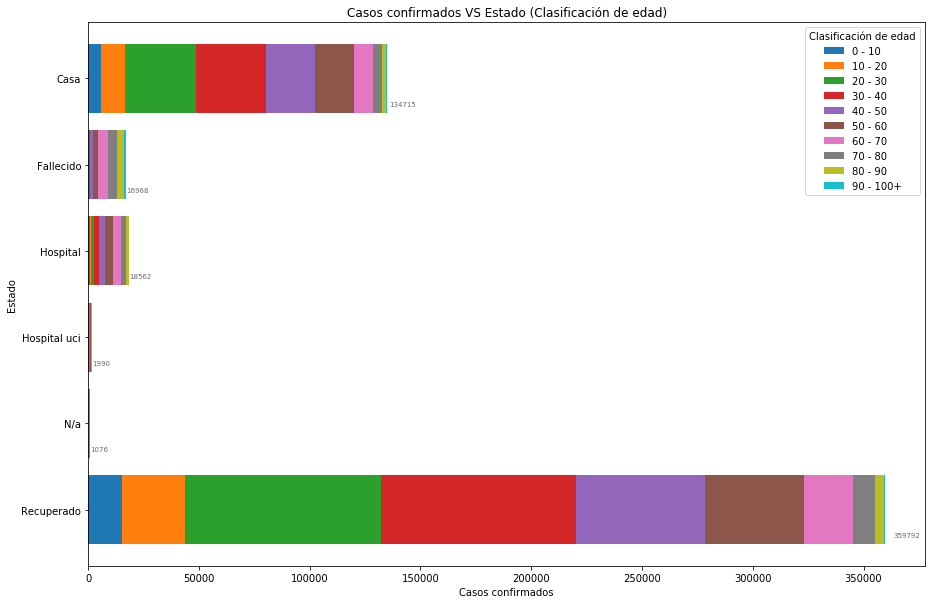

In [43]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [44]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     5946    10615    32301    31622    21990    17407   
Fallecido                  30       26      220      561     1260     2583   
Hospital                  803      404     1517     2186     2696     3766   
Hospital uci               53       34       77      186      295      491   
N/a                        26       20       48       38       85      131   
Recuperado              15310    28619    88396    87952    58130    44633   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      8648     4117     1762        307  
Fallecido                 4107     4295     3166        720  
Hospital                  3516     2368     1128        178  
Hospital uci               467      292       85         10  
N/a                        219      249      208         52  
Recuperado               22253     9981     3886        632

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

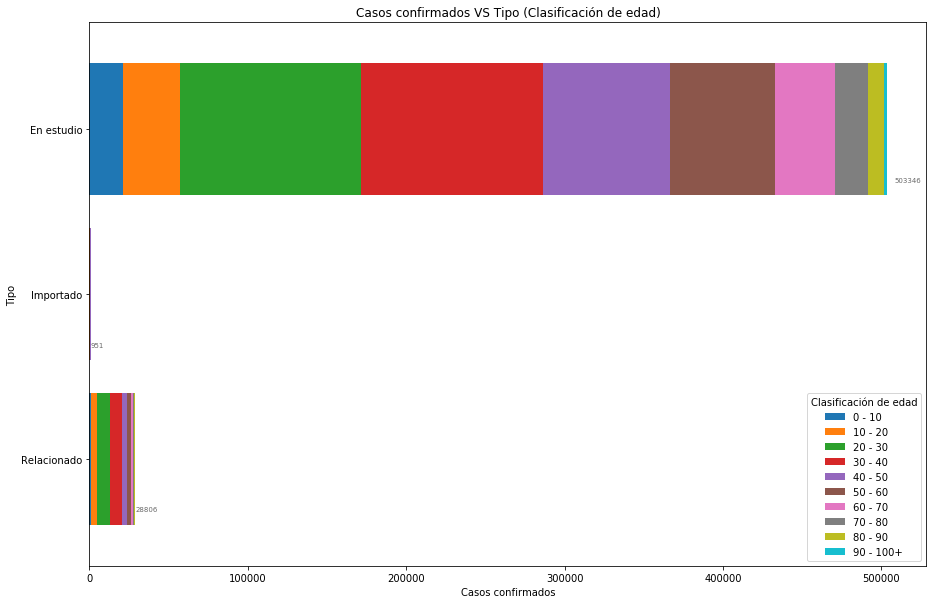

In [45]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [46]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              21181    36010   114123   114869    80644    66368   
Importado                   5       37      240      221      166      143   
Relacionado               982     3671     8196     7455     3646     2500   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               37811    20681     9854       1805  
Importado                   94       35        9          1  
Relacionado               1305      586      372         93

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>